In [1]:
from __future__ import (division, print_function, unicode_literals,
                        absolute_import)  # for Python 2.7

import numpy as np
import operator
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

# In production:
#from secondlayer import gdummynv
#from secondlayer import compute_error_v
#from secondlayer import compute_currents

# During debugging:
from secondlayer import _gdummynv_jit as gdummynv
from secondlayer import _compute_error_v_jit as compute_error_v
from secondlayer import _compute_currents_jit as compute_currents

In [2]:
# Adrien's playground
from matplotlib.ticker import EngFormatter, MultipleLocator, MaxNLocator

plt.style.use('default')  # simply because I use different style @home...

# One will use our own instance of RandomState to ensure global reproducibility
# Usage is exactly the same as `np.random`, which is an RS instance actually ;).
global_seed = 293674  # NB: use None to use random seed
prng = np.random.RandomState(global_seed)

In [3]:
# This is pre-processing to normalize the data in the [0..1] range for voltage prez
iris = datasets.load_iris()
min1 = min(iris.data[:,0])
ra1 = (max(iris.data[:,0]) -min1)
min2 = min(iris.data[:,1])
ra2 = (max(iris.data[:,1]) -min2)
min3 = min(iris.data[:,2])
ra3 = (max(iris.data[:,2])-min3)
min4 = min(iris.data[:,3])
ra4 =  (max(iris.data[:,3])-min4)
iris.data[:,0] = 2*((iris.data[:,0]-min1)/ra1)-1
iris.data[:,1] = 2*((iris.data[:,1]-min2)/ra2)-1
iris.data[:,2] = 2*((iris.data[:,2]-min3)/ra3)-1
iris.data[:,3] = 2*((iris.data[:,3]-min4)/ra4)-1

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=prng)
# For operator's eyes
print(f"Training:\nX.shape: {X_train.shape}\ny.shape: {y_train.shape}\n")
print(f"Testing:\nX.shape: {X_test.shape}\ny.shape: {y_test.shape}\n")

Training:
X.shape: (105, 4)
y.shape: (105,)

Testing:
X.shape: (45, 4)
y.shape: (45,)



In [5]:
nfts = 4  # number of features
ncls = 3  # number of classes
gmin = 1e-8  # Siemens
gmax = 1e-6  # Siemens
gf = 5e5  # scaling factor of the currents in neuron activation function.

# NB: the conductance array is ``2*(nfts + 1)`` row-high because
# each synapse is made of 2 devices, as well as the bias ("+ 1"). 
G = prng.uniform(low=gmin, high=gmax, size=(2*nfts + 2, ncls))
g = 256 # writable levels

nb_epochs = 50  # how many total cycles we present all train/test sets?
#momentum = np.zeros(nbepochs)
nb_train_steps = len(y_train)
nb_test_steps = len(y_test)

results = np.zeros(nb_epochs)
for k in range(nb_epochs):

    # Run Model on Train Set

    for it in range(nb_train_steps):

        xit = X_train[it, :]        
        yit = -1.0 * np.ones(G.shape[1])
        yit[y_train[it]] = 1
        
        currents = compute_currents(xit, G)
        outs = np.tanh(gf * currents)
        #deltas = np.abs(yit - outs)

        error = compute_error_v(xit, yit, outs)
        G = gdummynv(G, gmax, gmin, g, nfts, ncls, error)

    # Evaluate Model on Test Set after the current epoch
    #
    # NB: As it is only inference steps, it should be more or less
    # possible to vectorize this loop if speed is an issue.

    correct = 0
    conf_arr = np.zeros((ncls, ncls))  # row is label, col is act
    for it in range(nb_test_steps):
        xit = X_test[it, :]
        ind = y_test[it]
        
        currents = compute_currents(xit, G)
        outs = np.tanh(gf * currents)

        max_index = np.argmax(outs)
        conf_arr[ind, max_index] += 1
        if max_index == ind:
            correct += 1

    results[k] = (correct / nb_test_steps) * 100


In [6]:
# Check that we did not break anything compared to what existed previously.
try:
    ref_filepath = "./reference_final_conductance.npy"  # recorded from a previous run (seed=293674)
    ref_G = np.load(ref_filepath)
    np.testing.assert_allclose(ref_G, G)
    print("This implementation seems consistent with the previous one :).")
except FileNotFoundError:
    print("WARNING: Did not found the file '" + ref_filepath + "'!\nRunning further...")
except AssertionError:
    w_string = "WARNING: Results seem different from the previous implementation :/."
    print("#" * len(w_string))
    print(w_string)
    print("#" * len(w_string))

This implementation seems consistent with the previous one :).


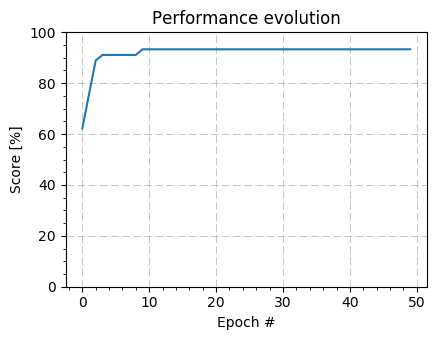

In [7]:
fig0, ax0 = plt.subplots(num="results", figsize=(4.5, 3.5))
fig, ax = fig0, ax0  # Copy-pasting is easier if one always use "ax." to call the methods ;).

ax.plot(range(len(results)), results)  # Actually "range(len(results))" is useless

# Cosmeticks
ax.set_title("Performance evolution")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Score [%]")
ax.set_ylim(0, 100)
ax.minorticks_on()
ax.grid(ls='dashed', lw=0.5)
fig.tight_layout()

plt.show()

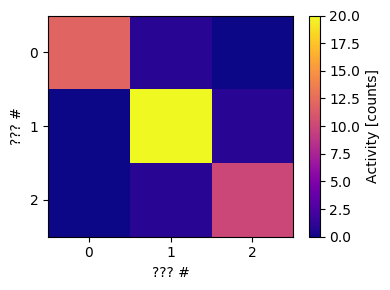

In [8]:
fig1, ax1 = plt.subplots(num="conf_arr", figsize=(4, 3))
fig, ax = fig1, ax1

im1 = ax.imshow(conf_arr, cmap='plasma', aspect='auto', origin='upper')
cb1 = fig.colorbar(im1, ax=ax, label="Activity [counts]")

# Cosmeticks
ax.set_xlabel("??? #")
ax.set_ylabel("??? #")
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
fig.tight_layout()

plt.show()

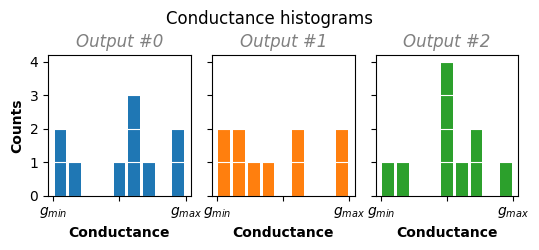

In [9]:
fig2, axs2 = plt.subplots(ncols=3, num="G_hist_1", figsize=(5.5, 2.5), sharex=True,
                          sharey=True)
fig, axs = fig2, axs2

custom_bins = np.linspace(gmin, gmax, 10)
for col, ax in enumerate(axs.flat):
    
    label = f'Output #{col}'  # or 'Output #{0}'.format(col) if Python < 3.6
    color = f'C{col}'  # col-th color of the cycle ('C{0}'.format(col) if Python < 3.6))
    ax.hist(G[:, col], bins=custom_bins, label=label, rwidth=0.8, color=color)

    if ax.is_first_col():
        ax.set_ylabel('Counts', weight='bold')

    if ax.is_first_row():
        ax.set_title(label, color='0.5', style='italic')

    if ax.is_last_row():
        ax.set_xlabel('Conductance', weight='bold')

    ax.set_xticks([gmin, (gmin + gmax)/2, gmax])
    ax.set_xticklabels(['$g_{min}$', '', '$g_{max}$'])
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5, integers=True))
    ax.grid(axis='y', color='white')  # little aesthetrick :)
    
# Global cosmeticks
fig.tight_layout()
fig.suptitle('Conductance histograms')
fig.subplots_adjust(wspace=0.15, top=0.8)

plt.show()

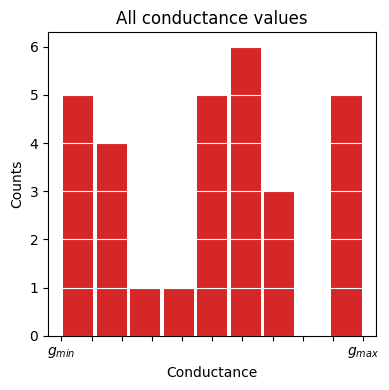

In [10]:
fig3, ax3 = plt.subplots(num="G_hist_2", figsize=(4, 4))
fig, ax = fig3, ax3

custom_bins = np.linspace(gmin, gmax, 10)  # or "auto"?
ax.hist(G.flat, bins=custom_bins, label='Final', rwidth=0.9, color='tab:red')
# NB: 'tab' in 'tab:red' stands for 'Tableau' which is the company that originally
# designed the palette used by Matplotlib 2+.
    
# Cosmeticks

ax.set_ylabel('Counts')
ax.set_title('All conductance values')
ax.set_xlabel('Conductance')

ticks = np.linspace(gmin, gmax, 11)
ax.set_xticks(ticks)
ax.set_xticklabels(['$g_{min}$'] + ['']*(len(ticks) - 2) + ['$g_{max}$'])

#ax.yaxis.set_major_locator(MaxNLocator(nbins=5, integers=True))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.grid(axis='y', color='white')  # little aesthetrick :)
fig.tight_layout()

plt.show()

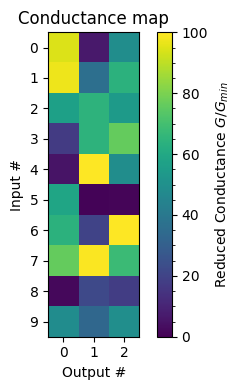

In [11]:
fig4, ax4 = plt.subplots(num="G_values", figsize=(4, 4))
fig, ax = fig4, ax4

im4 = ax.imshow(G/gmin, cmap='viridis', aspect='equal', origin='upper',
                vmin=0, vmax=gmax/gmin)
cb4 = fig.colorbar(im4, ax=ax, label="Reduced Conductance $G/G_{min}$")

# Cosmeticks
ax.set_title('Conductance map')
ax.set_xlabel("Output #")
ax.set_ylabel("Input #")
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
#cb4.ax.yaxis.set_major_locator(MaxNLocator(nbins=4))  # Avoid too many major ticks
cb4.ax.minorticks_on()
fig.tight_layout()

plt.show()